In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
START_DROPOUT_RATE = 0.05
DROPOUT_INCREMENT_RATE = 0.01

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()     
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(START_DROPOUT_RATE)
        )
        self.pool1 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(START_DROPOUT_RATE + DROPOUT_INCREMENT_RATE * 3)
        ) 
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(START_DROPOUT_RATE + DROPOUT_INCREMENT_RATE * 3)
        )   

        # self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        # self.conv4 = nn.Sequential(
        #     nn.Conv2d(32, 32, 3, padding=0),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(32)
        # )   

        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(START_DROPOUT_RATE + DROPOUT_INCREMENT_RATE * 3)
         ) 

        self.gap = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        
        self.fcs = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(START_DROPOUT_RATE),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
        )
    


    def forward(self, x):
        x = self.pool1(self.conv2(self.conv1(x)))
        x = self.pool2(self.conv3(x))

        x = self.gap(x)

        x = x.view(x.size(0), -1)

        x = self.fcs(x)

        return F.log_softmax(x,dim=1)

In [3]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
       BatchNorm2d-3           [-1, 32, 28, 28]              64
            Conv2d-4           [-1, 32, 26, 26]           9,248
              ReLU-5           [-1, 32, 26, 26]               0
       BatchNorm2d-6           [-1, 32, 26, 26]              64
           Dropout-7           [-1, 32, 26, 26]               0
         MaxPool2d-8           [-1, 32, 13, 13]               0
           Dropout-9           [-1, 32, 13, 13]               0
           Conv2d-10           [-1, 32, 11, 11]           9,248
             ReLU-11           [-1, 32, 11, 11]               0
      BatchNorm2d-12           [-1, 32, 11, 11]              64
          Dropout-13           [-1, 32, 11, 11]               0
        MaxPool2d-14             [-1, 3

In [4]:


torch.manual_seed(1)
batch_size = 256

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomApply([transforms.CenterCrop(20), ], p=0.05),
                        transforms.Resize((28, 28)),
                        transforms.RandomRotation((-15., 15.), fill=0),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [5]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [6]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))


In [7]:
# from tqdm import tqdm
# def train(model, device, train_loader, optimizer, epoch):
#     model.train()
#     pbar = tqdm(train_loader)
#     for batch_idx, (data, target) in enumerate(pbar):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.nll_loss(output, target)
#         loss.backward()
#         optimizer.step()
#         pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            # pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            correct += GetCorrectPredCount(output, target)
            # correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [8]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

for epoch in range(1, 20):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Epoch 1


Train: Loss=0.6049 Batch_id=234 Accuracy=61.82: 100%|██████████| 235/235 [00:14<00:00, 16.10it/s]



Test set: Average loss: 0.1973, Accuracy: 9485/10000 (95%)

Epoch 2


Train: Loss=0.3197 Batch_id=234 Accuracy=90.36: 100%|██████████| 235/235 [00:15<00:00, 15.38it/s]



Test set: Average loss: 0.1119, Accuracy: 9676/10000 (97%)

Epoch 3


Train: Loss=0.2685 Batch_id=234 Accuracy=93.02: 100%|██████████| 235/235 [00:15<00:00, 15.30it/s]



Test set: Average loss: 0.0982, Accuracy: 9700/10000 (97%)

Epoch 4


Train: Loss=0.1190 Batch_id=234 Accuracy=94.04: 100%|██████████| 235/235 [00:15<00:00, 15.18it/s]



Test set: Average loss: 0.0818, Accuracy: 9772/10000 (98%)

Epoch 5


Train: Loss=0.2292 Batch_id=234 Accuracy=95.02: 100%|██████████| 235/235 [00:15<00:00, 15.04it/s]



Test set: Average loss: 0.0663, Accuracy: 9800/10000 (98%)

Epoch 6


Train: Loss=0.1686 Batch_id=234 Accuracy=95.21: 100%|██████████| 235/235 [00:15<00:00, 14.83it/s]



Test set: Average loss: 0.0764, Accuracy: 9769/10000 (98%)

Epoch 7


Train: Loss=0.1083 Batch_id=234 Accuracy=95.79: 100%|██████████| 235/235 [00:15<00:00, 15.22it/s]



Test set: Average loss: 0.0776, Accuracy: 9759/10000 (98%)

Epoch 8


Train: Loss=0.1361 Batch_id=234 Accuracy=95.94: 100%|██████████| 235/235 [00:16<00:00, 14.46it/s]



Test set: Average loss: 0.0504, Accuracy: 9857/10000 (99%)

Epoch 9


Train: Loss=0.0680 Batch_id=234 Accuracy=96.18: 100%|██████████| 235/235 [00:15<00:00, 15.26it/s]



Test set: Average loss: 0.0555, Accuracy: 9825/10000 (98%)

Epoch 10


Train: Loss=0.1388 Batch_id=234 Accuracy=96.30: 100%|██████████| 235/235 [00:15<00:00, 14.77it/s]



Test set: Average loss: 0.0607, Accuracy: 9807/10000 (98%)

Epoch 11


Train: Loss=0.1396 Batch_id=234 Accuracy=96.58: 100%|██████████| 235/235 [00:15<00:00, 14.98it/s]



Test set: Average loss: 0.0550, Accuracy: 9833/10000 (98%)

Epoch 12


Train: Loss=0.1861 Batch_id=234 Accuracy=96.59: 100%|██████████| 235/235 [00:18<00:00, 12.95it/s]



Test set: Average loss: 0.0526, Accuracy: 9831/10000 (98%)

Epoch 13


Train: Loss=0.0739 Batch_id=234 Accuracy=96.68: 100%|██████████| 235/235 [00:15<00:00, 14.73it/s]



Test set: Average loss: 0.0428, Accuracy: 9859/10000 (99%)

Epoch 14


Train: Loss=0.1355 Batch_id=234 Accuracy=96.75: 100%|██████████| 235/235 [00:15<00:00, 14.80it/s]



Test set: Average loss: 0.0440, Accuracy: 9865/10000 (99%)

Epoch 15


Train: Loss=0.1403 Batch_id=234 Accuracy=96.75: 100%|██████████| 235/235 [00:15<00:00, 14.79it/s]



Test set: Average loss: 0.0561, Accuracy: 9824/10000 (98%)

Epoch 16


Train: Loss=0.0189 Batch_id=234 Accuracy=96.84: 100%|██████████| 235/235 [00:16<00:00, 14.67it/s]



Test set: Average loss: 0.0557, Accuracy: 9833/10000 (98%)

Epoch 17


Train: Loss=0.0521 Batch_id=234 Accuracy=96.90: 100%|██████████| 235/235 [00:16<00:00, 14.55it/s]



Test set: Average loss: 0.0358, Accuracy: 9880/10000 (99%)

Epoch 18


Train: Loss=0.0857 Batch_id=234 Accuracy=97.07: 100%|██████████| 235/235 [00:15<00:00, 14.91it/s]



Test set: Average loss: 0.0463, Accuracy: 9848/10000 (98%)

Epoch 19


Train: Loss=0.2198 Batch_id=234 Accuracy=96.96: 100%|██████████| 235/235 [00:16<00:00, 14.37it/s]



Test set: Average loss: 0.0411, Accuracy: 9873/10000 (99%)



Text(0.5, 1.0, 'Test Accuracy')

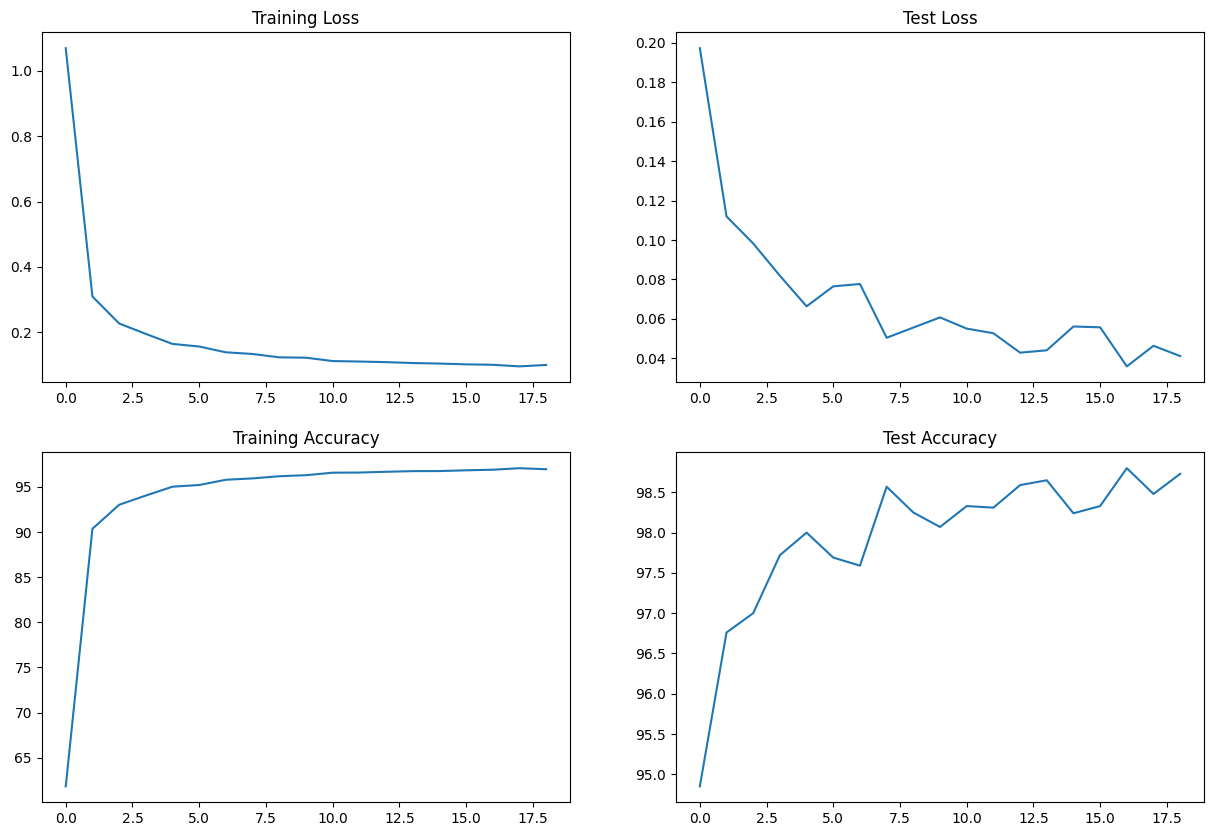

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")